In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.5.0


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/lunchjet/
!mkdir src && cd src && git clone https://github.com/kimito/lunchjet.git
%ls

/content/drive/MyDrive/lunchjet
mkdir: cannot create directory ‘src’: File exists
src/  train_2021_06_03_04_30_41.tar.gz


In [5]:
import pathlib
import os
import glob

for tarball_path in glob.glob("./*.tar.gz"):
  data_root_org = tf.keras.utils.get_file(fname='dataset', origin='file://' + os.path.abspath(tarball_path) , extract=True)
data_root = pathlib.Path(pathlib.Path(data_root_org).parents[0]/'control')
print(data_root)

164814848/164812768 [==============================] - 4s 0us/step
/root/.keras/datasets/control


In [6]:
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/control/images
/root/.keras/datasets/control/annotations


In [7]:
annot_paths = sorted(list(pathlib.Path(data_root/'annotations').glob("*")))
print(len(annot_paths))
print(annot_paths[-10:])

6469
[PosixPath('/root/.keras/datasets/control/annotations/2021_05_22_12_03_47_209.log'), PosixPath('/root/.keras/datasets/control/annotations/2021_05_22_12_03_47_273.log'), PosixPath('/root/.keras/datasets/control/annotations/2021_05_22_12_03_47_341.log'), PosixPath('/root/.keras/datasets/control/annotations/2021_05_22_12_03_47_409.log'), PosixPath('/root/.keras/datasets/control/annotations/2021_05_22_12_03_47_477.log'), PosixPath('/root/.keras/datasets/control/annotations/2021_05_22_12_03_47_541.log'), PosixPath('/root/.keras/datasets/control/annotations/2021_05_22_12_03_47_609.log'), PosixPath('/root/.keras/datasets/control/annotations/2021_05_22_12_03_47_677.log'), PosixPath('/root/.keras/datasets/control/annotations/2021_05_22_12_03_47_777.log'), PosixPath('/root/.keras/datasets/control/annotations/2021_05_22_12_03_47_805.log')]


/root/.keras/datasets/control/images/2021_05_22_12_01_10_952.jpg


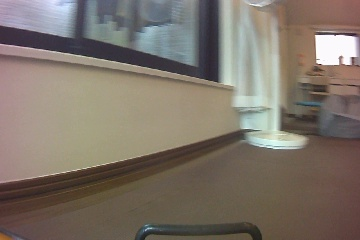

/root/.keras/datasets/control/images/2021_05_22_12_02_27_367.jpg


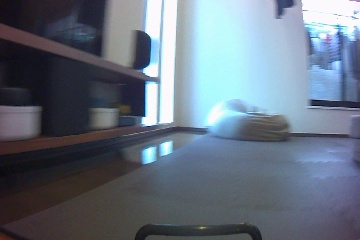

/root/.keras/datasets/control/images/2021_05_22_11_53_36_081.jpg


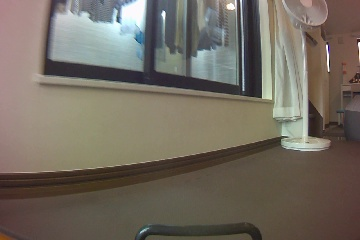

In [8]:
import IPython.display as display
import random

image_root = data_root/'images'

for n in range(3):
  annot_path = random.choice(annot_paths)
  with open(annot_path) as f:
    image_path, _, _ = f.readline().split(' ')
    image_path = str(image_root/image_path)
    print(image_path)
    display.display(display.Image(image_path))

In [9]:
def preprocess_image(img_path):
  image_raw = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image_raw, channels=3)
  image = tf.image.resize(image, [224, 224])
  image /= 255.0
  return image

In [10]:
image_paths = []
labels = []
for annot_file in annot_paths:
  with open(annot_file) as annot:
    for line in annot:
      image, steer, speed = line.split(' ')
      image_paths.append(str(image_root/image))
      labels.append([float(steer), float(speed)])

print(len(image_paths))
print(len(labels))

6469
6469


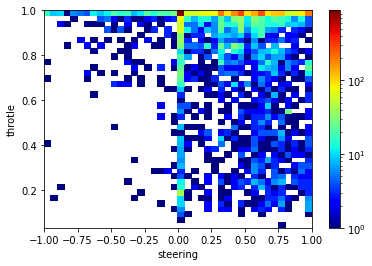

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors

steers = np.array(labels)[:, 0]
throtles = np.array(labels)[:, 1]

fig = plt.figure()
# plt.scatter(steers, throtles)
hist = plt.hist2d(steers, throtles, bins=40, cmap=cm.jet, norm=matplotlib.colors.LogNorm())
fig.colorbar(hist[3])
plt.xlabel('steering')
plt.ylabel('throtle')
plt.show()

In [11]:
image_paths_ds = tf.data.Dataset.from_tensor_slices(image_paths)
image_ds = image_paths_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

print(image_ds)

<ParallelMapDataset shapes: (224, 224, 3), types: tf.float32>


In [12]:
label_ds = tf.data.Dataset.from_tensor_slices(labels)

ds = tf.data.Dataset.zip((image_ds, label_ds))
print(ds)

<ZipDataset shapes: ((224, 224, 3), (2,)), types: (tf.float32, tf.float32)>


In [13]:
BATCH_SIZE = 64

ds = ds.shuffle(buffer_size=len(labels))
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>

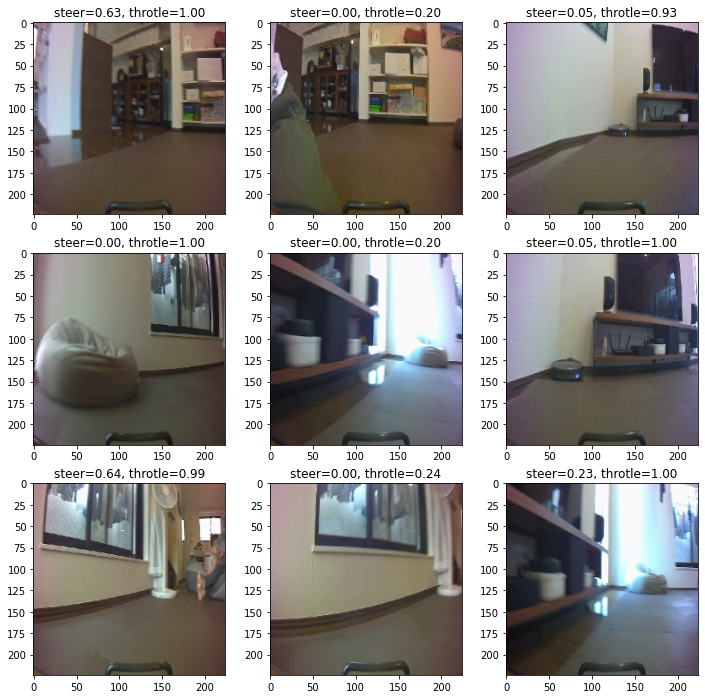

In [20]:
for batch in ds.take(1):
  images, labels = batch
  fig = plt.figure(figsize=(12.0, 12.0))
  for i in range(9):
    image = images[i]
    label = labels[i]
    label = 'steer={}, throtle={}'.format(tf.strings.as_string(label[0], precision=2).numpy().decode('utf-8'), tf.strings.as_string(label[1], precision=2).numpy().decode('utf-8'))

    subplot = fig.add_subplot(3, 3, i+1)
    subplot.imshow(image)
    subplot.grid(False)
    subplot.set_title(label)
    print()